# Quantium Virtual Internship - Task 1
## Retail Strategy & Analytics

**Name:** Het Lathiya  
**Task:** Analyze chip purchasing behavior and recommend a strategy to Julia (Category Manager)

---


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from datetime import datetime

In [8]:
from scipy.stats import ttest_ind

sns.set(style='whitegrid')

In [3]:
trans = pd.read_excel('QVI_transaction_data.xlsx')
cust = pd.read_csv('QVI_purchase_behaviour.csv')

In [4]:
trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264836 entries, 0 to 264835
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   DATE            264836 non-null  int64  
 1   STORE_NBR       264836 non-null  int64  
 2   LYLTY_CARD_NBR  264836 non-null  int64  
 3   TXN_ID          264836 non-null  int64  
 4   PROD_NBR        264836 non-null  int64  
 5   PROD_NAME       264836 non-null  object 
 6   PROD_QTY        264836 non-null  int64  
 7   TOT_SALES       264836 non-null  float64
dtypes: float64(1), int64(6), object(1)
memory usage: 16.2+ MB


In [5]:
cust.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72637 entries, 0 to 72636
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   LYLTY_CARD_NBR    72637 non-null  int64 
 1   LIFESTAGE         72637 non-null  object
 2   PREMIUM_CUSTOMER  72637 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [7]:
trans['DATE'] = pd.to_datetime(trans['DATE'], origin='1899-12-30', unit='D')

In [9]:
trans = trans[~trans['PROD_NAME'].str.contains("salsa", case=False)]

In [12]:
trans['PROD_QTY'].describe()

count    246742.000000
mean          1.908062
std           0.659831
min           1.000000
25%           2.000000
50%           2.000000
75%           2.000000
max         200.000000
Name: PROD_QTY, dtype: float64

In [13]:
outlier_ids = trans[trans['PROD_QTY'] == 200 ]['LYLTY_CARD_NBR'].unique()

In [14]:
trans = trans[~trans['LYLTY_CARD_NBR'].isin(outlier_ids)]

In [16]:
trans['PACK_SIZE'] = trans['PROD_NAME'].str.extract(r'(\d+)\s?g').astype(float)

In [17]:
trans['BRAND'] = trans['PROD_NAME'].str.extract(r'^([A-Za-z]+)')


In [18]:
brand_map = {'RRD': 'RED', 'SWW': 'SMITH'}
trans['BRAND'] = trans['BRAND'].replace(brand_map)


In [19]:
#Merge Customer Data
data = pd.merge(trans, cust, on='LYLTY_CARD_NBR', how='left')


In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246740 entries, 0 to 246739
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   DATE              246740 non-null  datetime64[ns]
 1   STORE_NBR         246740 non-null  int64         
 2   LYLTY_CARD_NBR    246740 non-null  int64         
 3   TXN_ID            246740 non-null  int64         
 4   PROD_NBR          246740 non-null  int64         
 5   PROD_NAME         246740 non-null  object        
 6   PROD_QTY          246740 non-null  int64         
 7   TOT_SALES         246740 non-null  float64       
 8   PACK_SIZE         240676 non-null  float64       
 9   BRAND             246740 non-null  object        
 10  LIFESTAGE         246740 non-null  object        
 11  PREMIUM_CUSTOMER  246740 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(5), object(4)
memory usage: 22.6+ MB


In [21]:
#EXPLORATORY DATA ANALYSIS

In [26]:
sales_by_seg = data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['TOT_SALES'].sum().reset_index()


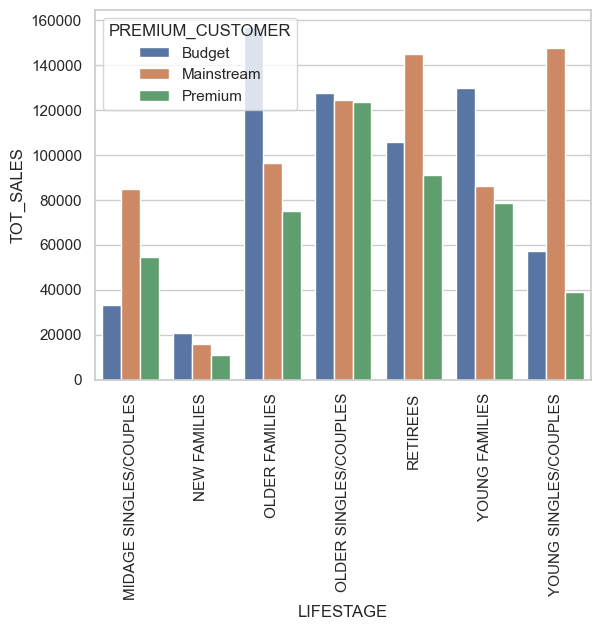

In [28]:
sns.barplot(
    data=sales_by_seg,
    x='LIFESTAGE',
    y='TOT_SALES',
    hue='PREMIUM_CUSTOMER'
)
plt.xticks(rotation=90)
plt.show()

In [29]:
cust_count = data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['LYLTY_CARD_NBR'].nunique()


In [31]:
#Avergae quantity per customer
avg_units = data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['PROD_QTY'].mean()


In [32]:
#Average price per unit
data['UNIT_PRICE'] = data['TOT_SALES'] / data['PROD_QTY']


In [33]:
avg_price = data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['UNIT_PRICE'].mean()


In [35]:
#T-TEST
#GROUP A : MAINSTREAM + YOUNG SINGLES
group_mainstream = data[
    (data['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES') &
    (data['PREMIUM_CUSTOMER'] == 'Mainstream')
]['UNIT_PRICE']

# Group B: Budget or Premium + Young Singles/Couples
group_others = data[
    (data['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES') &
    (data['PREMIUM_CUSTOMER'] != 'Mainstream')
]['UNIT_PRICE']

In [38]:
# Step 3: Run independent t-test (Welch's t-test, which doesn't assume equal variance)
t_stat, p_val = ttest_ind(group_mainstream, group_others, equal_var=False)

In [39]:
print("T-test Results:")
print(f"  T-statistic: {t_stat:.4f}")
print(f"  P-value:     {p_val:.6f}")

T-test Results:
  T-statistic: 34.8351
  P-value:     0.000000


In [41]:
if p_val < 0.05:
    print("✅ Statistically significant: Mainstream and other young singles/couples pay different prices per unit.")
else:
    print("❌ Not statistically significant: No strong evidence of price difference.")

✅ Statistically significant: Mainstream and other young singles/couples pay different prices per unit.


In [42]:
target = data[(data['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES') & (data['PREMIUM_CUSTOMER'] == 'Mainstream')]
brand_pref = target['BRAND'].value_counts(normalize=True) * 100


In [43]:
pack_pref = target['PACK_SIZE'].value_counts(normalize=True) * 100


In [44]:
data.to_csv('QVI_cleaned_data.csv', index=False)


## Final Recommendation to Julia

- The top spending segments are:
  - Mainstream – Young Singles/Couples
  - Mainstream – Retirees
  - Budget – Older Families

- Mainstream Young Singles/Couples show:
  - Higher unit price willingness
  - Brand loyalty to KETTLE, SMITHS, and INFZ

🧠 **Strategy:**
Offer tailored promotions (e.g. buy 2 get 1, exclusive flavors) targeting Mainstream Young Singles/Couples via digital coupons or store displays, as they are high spenders with brand awareness and room for upselling.

